In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython import display
from gym.wrappers import RecordVideo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
from collections import deque
import random
from tqdm import tqdm
import os

os.makedirs("videos", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, log_std_min=-20, log_std_max=2):
        """
        Actor network for the SAC algorithm that outputs a continuous action distribution.
        
        Args:
            state_dim   : Dimension of the state space
            action_dim  : Dimension of the action space
            hidden_dim  : Dimension of hidden layers
            log_std_min : Minimum value for log standard deviation
            log_std_max : Maximum value for log standard deviation
        """
        super(Actor, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Separate layers for mean and log_std of the action distribution
        self.mean_linear = nn.Linear(hidden_dim, action_dim)
        self.log_std_linear = nn.Linear(hidden_dim, action_dim)

        self.apply(weights_init_)
        
    def forward(self, state):
        """
        Forward pass to compute action distribution parameters.
        
        Args:
            state   :  Current state (torch.Tensor)
            
        Returns:
            tuple   :  the action distribution (mean, log_std) 
        """
        
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def sample(self, state):
        """
        Sample actions from the policy using the reparameterization trick.
        
        Args:
            state   : Current state (torch.Tensor)
            
        Returns:
            tuple   : (sampled_action, log_prob, mean, log_std)
        """
        
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        # Reparameterization trick: sample from standard normal and transform
        x_t = normal.rsample()

        # Scale and bias the tanh output to match action space
        action_scale = torch.FloatTensor([1.0]).to(mean.device)
        action_bias = torch.FloatTensor([0.0]).to(mean.device)
        action = torch.tanh(x_t) * action_scale + action_bias
        
        # Apply tanh correction to log probability
        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(action_scale * (1 - action.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        
        return action, log_prob, mean, log_std


In [2]:
class Critic(nn.Module):
    """
    Twin Critic networks for SAC algorithm that estimate Q-values.
    
    Args:
        state_dim   : Dimension of the state space
        action_dim  : Dimension of the action space
        hidden_dim  : Dimension of hidden layers
    """
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        
        # Q1 architecture
        self.linear1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        # Q2 architecture
        self.linear4 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)
        
    def forward(self, state, action):
        """
        Forward pass through both Q-networks.
        
        Args:
            state   : Current state (torch.Tensor)
            action  : Current action (torch.Tensor)
            
        Returns:
            tuple   : (Q1_value, Q2_value)
        """
        
        x = torch.cat([state, action], 1)
        
        # Q1
        x1 = F.relu(self.linear1(x))
        x1 = F.relu(self.linear2(x1))
        q1 = self.linear3(x1)
        
        # Q2
        x2 = F.relu(self.linear4(x))
        x2 = F.relu(self.linear5(x2))
        q2 = self.linear6(x2)
        
        return q1, q2

In [3]:
def weights_init_(m):
    """
    Initialize network weights using Xavier initialization.
    
    Args:
        m   : Neural network module (nn.Module)
    """
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ReplayBuffer:
    """
    Circular buffer for storing and sampling transitions.
    
    Args:
        capacity: Maximum number of transitions to store
    """
    
    def __init__(self, capacity=1000000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """
        Store a transition in the buffer.
        
        Args:
            state       : Current state
            action      : Action taken
            reward      : Reward received
            next_state  : Next state
            done        : Boolean indicating if episode ended
        """
        
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """
        Sample a batch of transitions from the buffer.
        
        Args:
            batch_size  : Number of transitions to sample
            
        Returns:
            tuple   : Batch of (state, action, reward, next_state, done)
        """
        transitions = random.sample(self.buffer, batch_size)
        batch = map(np.array, zip(*transitions))
        return tuple(map(torch.FloatTensor, batch))
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
class SAC:
    """
    Soft Actor-Critic (SAC) agent implementation.
    
    Args:
        env         : Gymnasium environment
        hidden_dim  : Hidden layer dimension for networks
        gamma       : Discount factor
        tau         : Soft update coefficient
        lr          : Learning rate
        batch_size  : Batch size for training
        device      : Device to run the agent on
    """
    def __init__(
        self, 
        env,
        hidden_dim=256,
        gamma=0.99,
        tau=0.005,
        lr=3e-4,
        batch_size=256,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.device = device
        
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        
        self.actor = Actor(self.state_dim, self.action_dim, hidden_dim).to(device)
        self.critic = Critic(self.state_dim, self.action_dim, hidden_dim).to(device)
        self.critic_target = Critic(self.state_dim, self.action_dim, hidden_dim).to(device)
        
        # Initialize target network with same parameters
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Automatic entropy tuning
        self.target_entropy = -torch.prod(torch.Tensor(env.action_space.shape)).item()
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha = self.log_alpha.exp()
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr)
        
        self.replay_buffer = ReplayBuffer()
        self.episode_rewards = []
        
    def select_action(self, state):
        """
        Select action using the current policy.
        
        Args:
            state       : Current state
            
        Returns:
            np.ndarray  : Selected action
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action, _, _, _ = self.actor.sample(state)
        return action.cpu().detach().numpy()[0]
    
    def update_parameters(self):
        """
        Update the parameters of actor and critic networks.
        """
        if len(self.replay_buffer) < self.batch_size:
            return
        
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = \
            self.replay_buffer.sample(self.batch_size)
        
        state_batch = state_batch.to(self.device)
        action_batch = action_batch.to(self.device)
        reward_batch = reward_batch.unsqueeze(1).to(self.device)
        next_state_batch = next_state_batch.to(self.device)
        done_batch = done_batch.unsqueeze(1).to(self.device)
        
        # Calculate target Q-value
        with torch.no_grad():
            next_action, next_log_pi, _, _ = self.actor.sample(next_state_batch)
            target_q1, target_q2 = self.critic_target(next_state_batch, next_action)
            target_q = torch.min(target_q1, target_q2) - self.alpha.detach() * next_log_pi
            target_q = reward_batch + (1 - done_batch) * self.gamma * target_q

        # Update critic            
        current_q1, current_q2 = self.critic(state_batch, action_batch)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update actor
        action, log_pi, _, _ = self.actor.sample(state_batch)
        q1, q2 = self.critic(state_batch, action)
        q = torch.min(q1, q2)
        actor_loss = (self.alpha.detach() * log_pi - q).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update temperature parameter
        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()

        # Soft update of target network
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def record_video(self, video_path='videos/trained_agent.mp4'):
        """
        Record a video of the trained agent's performance.
        
        Args:
            video_path  : Path to save the video
            
        Returns:
            float       : Total reward obtained during recording
        """
        video_env = RecordVideo(
            gym.make("HalfCheetah-v4", render_mode="rgb_array"),
            video_path,
            episode_trigger=lambda x: True
        )
        
        state, _ = video_env.reset()
        done = False
        truncated = False
        total_reward = 0
        
        while not (done or truncated):
            action = self.select_action(state)
            state, reward, done, truncated, _ = video_env.step(action)
            total_reward += reward
            
        video_env.close()
        return total_reward

    def plot_progress(self):
        """Plot training progress showing episode rewards."""

        plt.figure(figsize=(8, 4))
        plt.plot(self.episode_rewards)
        plt.title('Training Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

    def train(self, max_episodes=2000):
        """
        Train the agent.
        
        Args:
            max_episodes    : Maximum number of episodes to train for
            
        Returns:
            list            : Episode rewards
        """
        self.episode_rewards = []
        total_steps = 0
        
        pbar = tqdm(total=max_episodes, desc='Training Progress')
        
        for episode in range(max_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            truncated = False
            
            while not (done or truncated):
                action = self.select_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                
                '''
                 Custom reward shaping for HalfCheetah as initially it was getting 
                 positive reward but was upside down, so added a negative penalty based 
                 on the orientation
                '''
                torso_height = state[0]
                orientation_penalty = -2.0 if torso_height < 0 else 1
                modified_reward = reward + orientation_penalty
                
                self.replay_buffer.push(state, action, modified_reward, next_state, float(done))
                
                state = next_state
                episode_reward += modified_reward
                total_steps += 1
                
                self.update_parameters()
            
            self.episode_rewards.append(episode_reward)
            
            if (episode + 1) % 50 == 0: 
                self.plot_progress()
            
            pbar.update(1)
            pbar.set_postfix({
                'episode': episode + 1,
                'reward': f'{episode_reward:.2f}'
            })
            
        pbar.close()
        return self.episode_rewards


In [ ]:

def run_multiple_trials(n_trials=10, max_episodes=2000):
    """
    Run multiple training trials and save models.
    
    Args:
        n_trials        : Number of training trials to run
        max_episodes    : Number of episodes per trial
        
    Returns:
        np.ndarray      : Array of training rewards for all trials
    """
    env = gym.make("HalfCheetah-v4")
    all_training_rewards = []
    
    for trial in range(n_trials):
        print(f"\nStarting Trial {trial + 1}/{n_trials}")
        
        agent = SAC(env)
        training_rewards = agent.train(max_episodes=max_episodes)
        
        all_training_rewards.append(np.array(training_rewards))
        
        torch.save({
            'actor_state_dict': agent.actor.state_dict(),
            'critic_state_dict': agent.critic.state_dict(),
            'critic_target_state_dict': agent.critic_target.state_dict(),
            'alpha': agent.alpha,
            'rewards': training_rewards,
        }, f'models/sac_half_cheetah_trial_{trial + 1}.pth')
         
        video_reward = agent.record_video(f'videos/trial_{trial + 1}_final.mp4')
        print(f"Trial {trial + 1} final reward: {video_reward:.2f}")
    
    env.close()
    return np.array(all_training_rewards)

In [ ]:
def plot_results(all_training_rewards):
    """
    Plot training results with mean and standard deviation.
    
    Args:
        all_training_rewards: Array of rewards from all training trials
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    mean_rewards = np.mean(all_training_rewards, axis=0)
    std_rewards = np.std(all_training_rewards, axis=0)
    episodes_range = np.arange(1, len(mean_rewards) + 1)
    plt.plot(episodes_range, mean_rewards, label='Mean', color='blue')
    plt.fill_between(episodes_range, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                     alpha=0.2, color='blue', label='Std Dev')
    plt.title('Training Rewards (Mean ± Std)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    
    plt.subplot(122)
    window_size = 50
    smoothed_rewards = []
    for rewards in all_training_rewards:
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        smoothed_rewards.append(smoothed)
    
    smoothed_rewards = np.array(smoothed_rewards)
    mean_smoothed = np.mean(smoothed_rewards, axis=0)
    std_smoothed = np.std(smoothed_rewards, axis=0)
    smoothed_range = np.arange(window_size, len(mean_rewards) + 1)
    plt.plot(smoothed_range, mean_smoothed, label='Mean', color='blue')
    plt.fill_between(smoothed_range, mean_smoothed - std_smoothed, mean_smoothed + std_smoothed,
                     alpha=0.2, color='blue', label='Std Dev')
    plt.title(f'Smoothed Training Rewards\n({window_size}-episode window)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    
    plt.show()



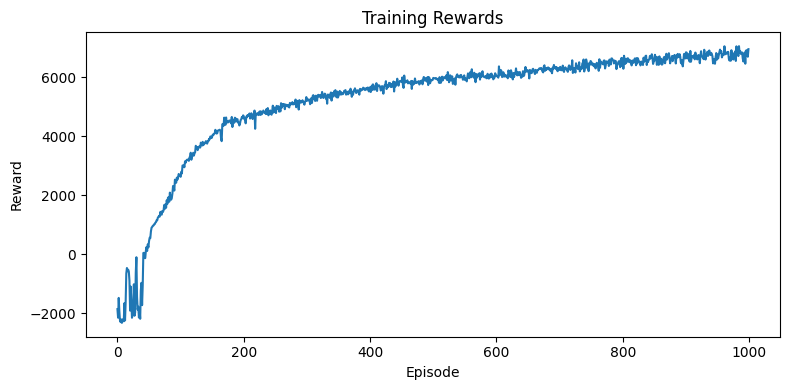

Training Progress: 100%|██████████| 1000/1000 [6:14:54<00:00, 22.49s/it, episode=1000, reward=6954.45]



Plot results


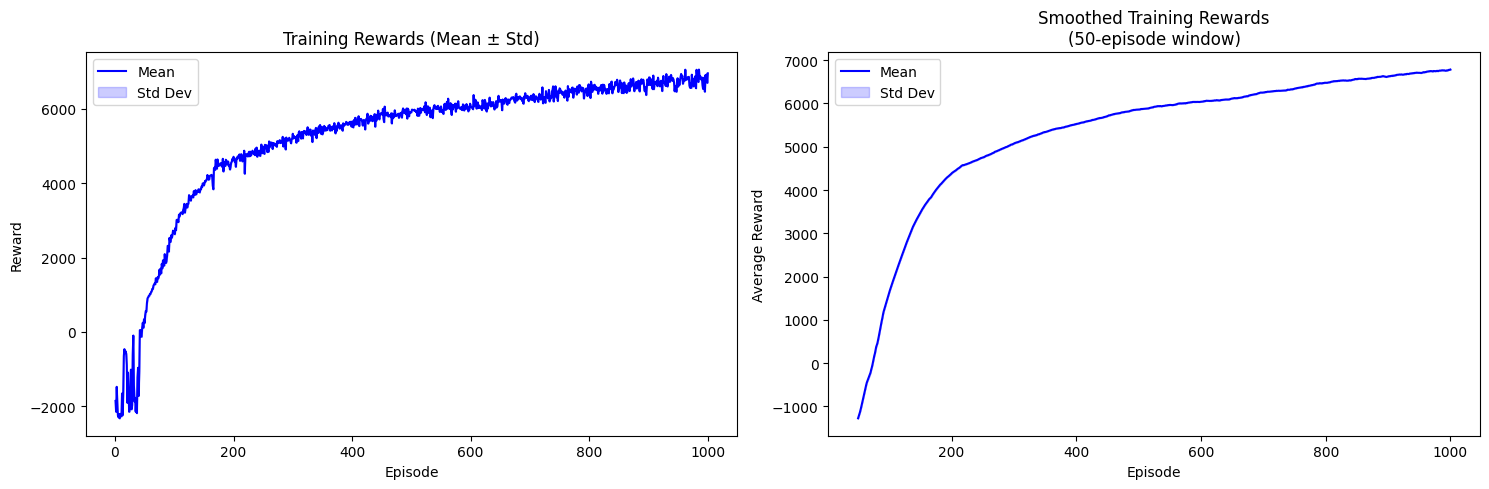

In [5]:
if __name__ == "__main__":
    all_training_rewards = run_multiple_trials(n_trials=1, max_episodes=1000)
    
    print("\nPlot results") 
    plot_results(all_training_rewards)
    